# Methods

## Our Method:
1. Import the data set.

2. Clean and wrangle data set to have a tidydata format.
3. Visualize relationships between variables of interest:
    1. Investment Activity vs Label (>= 50k, > 50k annual income)
        1. Bar graph
        2. X-Axis: Label 
        3. Y-Axis: Count of Capital Gains and Capital Losses
    2. Capital Gains vs Age
        1. Scatter plot
        2. X-Axis: Age 
        3. Y-Axis: Capital Gains (USD)
    3. Working Hours per Week vs Age
        1. Scatter plot
        2. X-Axis: Age
        3. Y-Axis: Working Hours per Week
        
4. Summarize the data set and address class imbalance if one label is more prevalent then the other.
5. Tune our classification model (k-nearest neighbours) using predictors of interest.
    1. Our dataset provided training and testing data, so we do not have to split our data set.
    2. Pre-process our training data (standardize and center).
    3. Create a 5 fold cross validation data split using vfold.
    4. Determine specifications for the nearest neighbour function.
        1. weight_func = "rectangular"
        2. neighbors = tune()
    5. Fit our model for each fold in our cross validation.
        3. tune_grid(resamples=vold,grid=10)
    6. Create a scatter plot of Accuracy vs k to determine the best k
    
6. Retrain our classification model (k-nearest neighbours) using our tuned k value and predictors of interest.
7. Evaluate the estimate accuracy of our classification model using our test data set.
    1. We may need to go back and try various values for #-fold cross validation and/or using different combinations of predictors.

## Visualizing Our Results:
One way to visualize our results is having several test points on 2D plots with various combinations of our predictors (e.g Capital Gains vs Age). We can use our model to classify these test points and outline them on the 2D plot to see whether the classification visually makes sense and to see whether gauge the weights of the variables in our classification model.


In [2]:
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(recipes)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [4]:
## Reads in data
adult <- read_delim("data/adult.data.txt", delim=",",col_names=c("age", "workclass", "fnl_wgt","education",
    "education_num","marital_status","occupation","relationship","race","sex","capital_gain","capital_loss",
    "hrs_per_week","native_country","label"))

Parsed with column specification:
cols(
  age = col_double(),
  workclass = col_character(),
  fnl_wgt = col_character(),
  education = col_character(),
  education_num = col_character(),
  marital_status = col_character(),
  occupation = col_character(),
  relationship = col_character(),
  race = col_character(),
  sex = col_character(),
  capital_gain = col_character(),
  capital_loss = col_character(),
  hrs_per_week = col_character(),
  native_country = col_character(),
  label = col_character()
)



In [5]:
## Cleaning and Wrangling
adult_tidy <- adult %>%
    mutate(label=as_factor(label), capital_gain = as.numeric(capital_gain), 
           capital_loss = as.numeric(capital_loss), hrs_per_week = as.numeric(hrs_per_week) ) %>%
    filter_all(all_vars(. != " ?")) %>%
    select(age,capital_gain,capital_loss,hrs_per_week,label) 
   
head(adult_tidy)

age,capital_gain,capital_loss,hrs_per_week,label
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
39,2174,0,40,<=50K
50,0,0,13,<=50K
38,0,0,40,<=50K
53,0,0,40,<=50K
28,0,0,40,<=50K
37,0,0,40,<=50K


In [6]:
adult_tidy %>%
    filter(capital_gain > 0)

age,capital_gain,capital_loss,hrs_per_week,label
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
39,2174,0,40,<=50K
31,14084,0,50,>50K
42,5178,0,40,>50K
30,5013,0,40,<=50K
30,2407,0,40,<=50K
44,14344,0,40,>50K
44,15024,0,60,>50K
32,7688,0,40,>50K
28,4064,0,25,<=50K


In [7]:
#Reading Adult Data
adult_data <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", delim=",",col_names=c("age", "workclass", "fnl_wgt","education",
    "education_num","marital_status","occupation","relationship","race","sex","capital_gain","capital_loss",
    "hrs_per_week","native_country","label"))

head(adult_data)

Parsed with column specification:
cols(
  age = col_double(),
  workclass = col_character(),
  fnl_wgt = col_character(),
  education = col_character(),
  education_num = col_character(),
  marital_status = col_character(),
  occupation = col_character(),
  relationship = col_character(),
  race = col_character(),
  sex = col_character(),
  capital_gain = col_character(),
  capital_loss = col_character(),
  hrs_per_week = col_character(),
  native_country = col_character(),
  label = col_character()
)



age,workclass,fnl_wgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hrs_per_week,native_country,label
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [8]:
## Cleaning and Wrangling
adult_tidy <- adult_data %>%
    mutate(label=as_factor(label), capital_gain = as.numeric(capital_gain), 
           capital_loss = as.numeric(capital_loss), hrs_per_week = as.numeric(hrs_per_week) ) %>%
    filter_all(all_vars(. != " ?")) %>%
    select(label,capital_gain)

head(adult_tidy)

label,capital_gain
<fct>,<dbl>
<=50K,2174
<=50K,0
<=50K,0
<=50K,0
<=50K,0
<=50K,0


In [9]:
set.seed(100)

knn_spec <- nearest_neighbor(weight_func="rectangular",neighbors=tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

In [ ]:
#no upsample
adult_recipe <- recipe(label~capital_gain,data=adult_tidy) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    prep()

upsampled_adult <- bake(adult_recipe,adult_tidy)

In [10]:
adult_vfold <- vfold_cv(adult_tidy, v = 5, strata = label)

In [11]:
knn_results <- workflow() %>%
    add_recipe(adult_recipe)%>%
    add_model(knn_spec)%>%
    tune_grid(resamples = adult_vfold, grid = 10)%>%
    collect_metrics()

ERROR: Error in is_recipe(recipe): object 'adult_recipe' not found


In [13]:
#with upsample
adult_recipe_2 <- recipe(label~capital_gain,data=adult_tidy) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    step_upsample(label, over_ratio = 1)
 

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [14]:
knn_results_2 <- workflow() %>%
    add_recipe(adult_recipe_2)%>%
    add_model(knn_spec)%>%
    tune_grid(resamples = adult_vfold, grid = 20)%>%
    collect_metrics()

In [32]:
knn_results_2

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.7990517,5,0.001701041,Model1
2,roc_auc,binary,0.5978743,5,0.002878258,Model1
3,accuracy,binary,0.7989523,5,0.001662507,Model2
3,roc_auc,binary,0.5977486,5,0.002906363,Model2
5,accuracy,binary,0.7987202,5,0.001716968,Model3
5,roc_auc,binary,0.6009749,5,0.003475040,Model3
7,accuracy,binary,0.7990519,5,0.001557187,Model4
7,roc_auc,binary,0.6018303,5,0.003129665,Model4
9,accuracy,binary,0.7992840,5,0.001847047,Model5


In [39]:
accuracies <- knn_results_2 %>%
    filter(.metric=="accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7990517,5,0.001701041,Model01
2,accuracy,binary,0.7990517,5,0.001701041,Model02
3,accuracy,binary,0.7989523,5,0.001662507,Model03
4,accuracy,binary,0.7989523,5,0.001662507,Model04
5,accuracy,binary,0.7987202,5,0.001716968,Model05
6,accuracy,binary,0.7987202,5,0.001716968,Model06
7,accuracy,binary,0.7990519,5,0.001557187,Model07
9,accuracy,binary,0.7992840,5,0.001847047,Model08
10,accuracy,binary,0.7992840,5,0.001847047,Model09


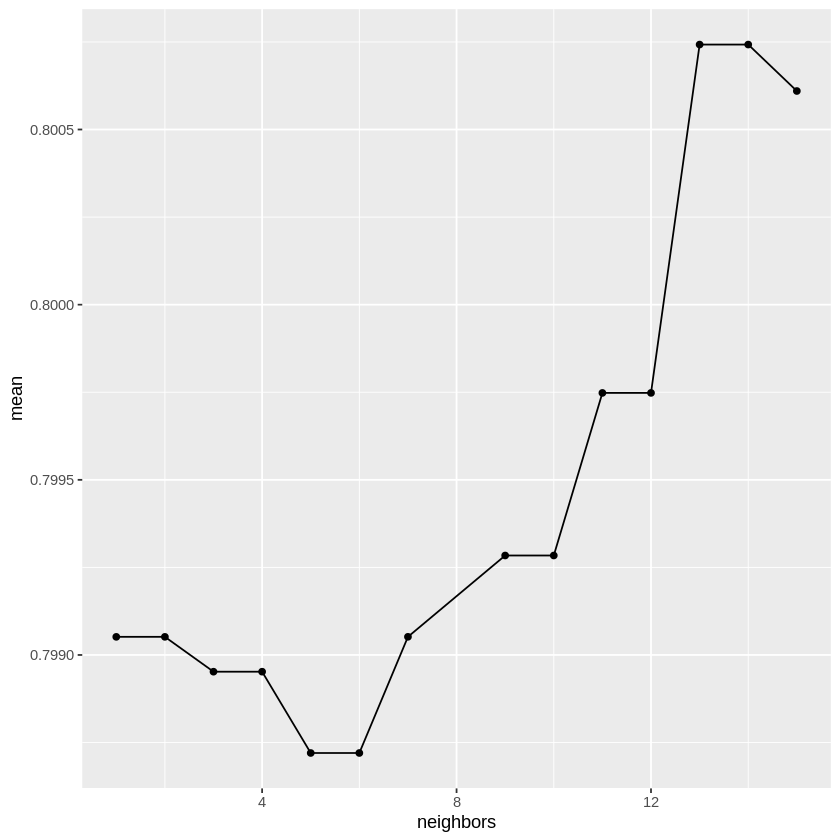

In [40]:
k_plot <- ggplot(accuracies , aes(x=neighbors,y=mean)) +
    geom_point()+
    geom_line()

k_plot